In [2]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re

In [4]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
float_pattern

re.compile(r'[0-9]+(\.[0-9]*)?', re.UNICODE)

In [5]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [35]:
with open("VDR_IC50.csv") as inp:
    vdr = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in vdr:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "vdr"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])

In [10]:
vdr

[{'Molecule ChEMBL ID': 'CHEMBL385265',
  'Molecule Name': '',
  'Molecule Max Phase': '0',
  'Molecular Weight': '540.79',
  '#RO5 Violations': '2',
  'AlogP': '6.30',
  'Compound Key': '81b',
  'Smiles': 'C=C1/C(=C\\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H](C)C[C@@H]2OC(=O)C(=C)[C@H]2CC(C)C)C[C@@H](O)[C@H](CCCO)[C@@H]1O',
  'Standard Type': 'IC50',
  'Standard Relation': "'='",
  'Standard Value': '9.3',
  'Standard Units': 'nM',
  'pChEMBL Value': '8.03',
  'Data Validity Comment': '',
  'Comment': '',
  'Uo Units': 'UO_0000065',
  'Ligand Efficiency BEI': '',
  'Ligand Efficiency LE': '',
  'Ligand Efficiency LLE': '',
  'Ligand Efficiency SEI': '',
  'Potential Duplicate': 'False',
  'Assay ChEMBL ID': 'CHEMBL910037',
  'Assay Description': 'Antagonist activity against 1-alpha,25-dihydroxy vitamin D3-induced HL60 cell differentiation by NBT reduction method',
  'Assay Type': 'F',
  'BAO Format ID': 'BAO_0000219',
  'BAO Label': 'cell-based format',
  'Assay Organism': 'Homo sapiens',


In [11]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("cdd2021/data/drugbank.sdf") if m
           ]

In [36]:
df = pd.DataFrame((*drugbank, *vdr), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)

In [37]:
df

index                                             Smiles    source  \
0         0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1         1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2         2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3         3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4         4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   
...     ...                                                ...       ...   
7751   7751       COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7752   7752        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7753   7753  C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...       vdr   
7754   7754  CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...       vdr   
7755   7755        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   

                                                 rdmol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf3a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bfee0>   
2     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf760>   
3     <rdkit.Chem.rdchem.Mol object at 0x7f20df4ceda0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7f20df2f1030>   
...                                                ...   
7751  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0aff30>   
7752  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1030>   
7753  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b10d0>   
7754  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1170>   
7755  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1210>   

                                                    fps  pChEMBL_value  HBA  \
0     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   29   
1     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
2     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   15   
3     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
4     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   12   
...                                                 ...            ...  ...   
7751  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...           5.54    6   
7752  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           6.18    6   
7753  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           8.95    3   
7754  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...           6.53    5   
7755  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    6   

      HBD           MW     LogP    TPSA  RB  
0      28  2178.985813 -8.11643  901.57  66  
1      17  1268.641439 -3.10570  495.89  31  
2      14  1068.426955 -4.13203  435.41  19  
3      17  1429.669818 -0.50613  495.67  38  
4       5  1201.841368  3.26900  278.80  15  
...   ...          ...      ...     ...  ..  
7751    0   381.157623  4.34322   70.79   8  
7752    0   367.141973  3.95312   70.79   7  
7753    3   416.329045  5.70470   60.69   6  
7754    2   541.424343  6.70422   66.73  18  
7755    0   367.141973  3.95312   70.79   7  

[7756 rows x 12 columns]

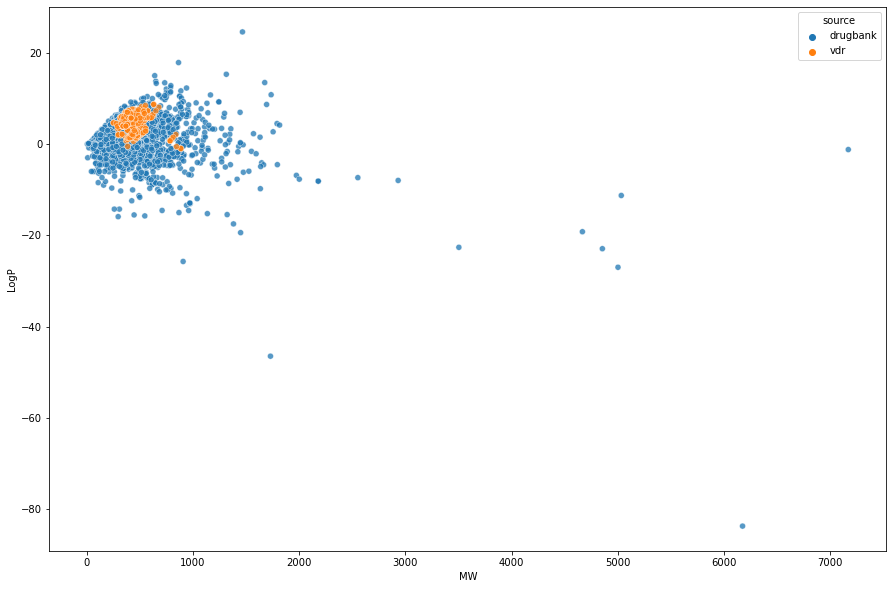

In [38]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

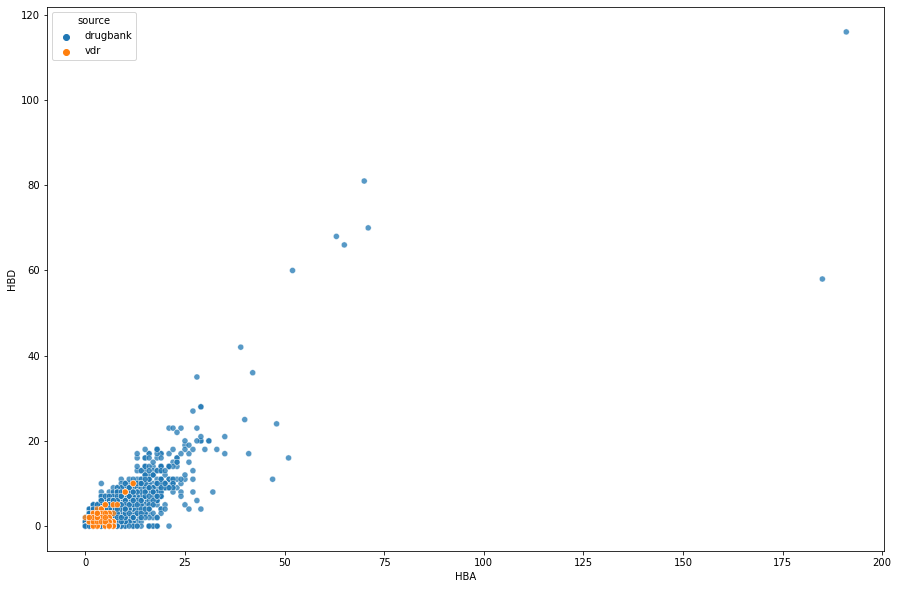

In [39]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [40]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [41]:
df

index                                             Smiles    source  \
0         0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1         1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2         2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3         3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4         4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   
...     ...                                                ...       ...   
7751   7751       COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7752   7752        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7753   7753  C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...       vdr   
7754   7754  CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...       vdr   
7755   7755        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   

                                                 rdmol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf3a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bfee0>   
2     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf760>   
3     <rdkit.Chem.rdchem.Mol object at 0x7f20df4ceda0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7f20df2f1030>   
...                                                ...   
7751  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0aff30>   
7752  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1030>   
7753  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b10d0>   
7754  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1170>   
7755  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1210>   

                                                    fps  pChEMBL_value  HBA  \
0     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   29   
1     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
2     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   15   
3     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
4     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   12   
...                                                 ...            ...  ...   
7751  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...           5.54    6   
7752  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           6.18    6   
7753  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           8.95    3   
7754  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...           6.53    5   
7755  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    6   

      HBD           MW     LogP  ...  MQN_33  MQN_34  MQN_35  MQN_36  MQN_37  \
0      28  2178.985813 -8.11643  ...       0       0       3       3       0   
1      17  1268.641439 -3.10570  ...       0       0       4       2       0   
2      14  1068.426955 -4.13203  ...       0       0       1       2       0   
3      17  1429.669818 -0.50613  ...       0       0       1       5       0   
4       5  1201.841368  3.26900  ...       0       0       0       0       0   
...   ...          ...      ...  ...     ...     ...     ...     ...     ...   
7751    0   381.157623  4.34322  ...       0       0       1       2       0   
7752    0   367.141973  3.95312  ...       0       0       1       2       0   
7753    3   416.329045  5.70470  ...       0       0       1       2       0   
7754    2   541.424343  6.70422  ...       0       0       1       1       0   
7755    0   367.141973  3.95312  ...       0       0       1       2       0   

      MQN_38  MQN_39  MQN_40  MQN_41  MQN_42  
0          0       0       0       0       0  
1          0       0       0       2       1  
2          0       0       1       0       0  
3          0       0       0       2       1  
4          0       0       1       0       0  
...      ...     ...     ...     ...     ...  
7751       0       0       0       0       0  
7752       0       0       0       0       0  
7753       0       0       0       2       1  
7754       0    

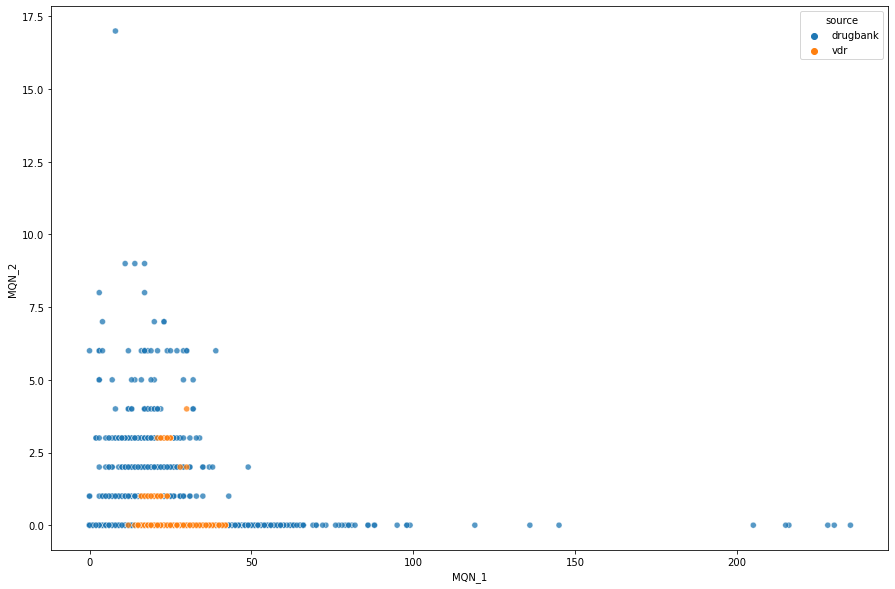

In [42]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

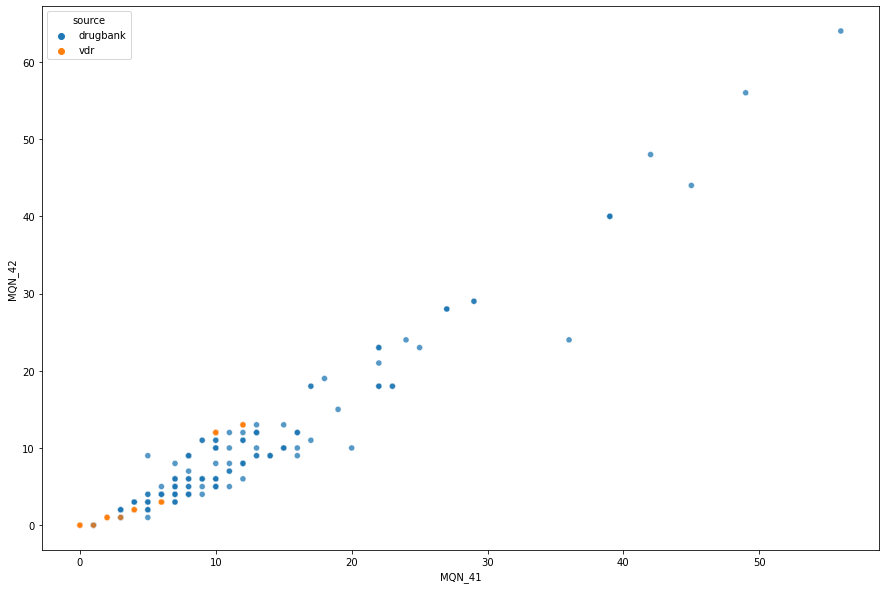

In [43]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_41",
                      y="MQN_42",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

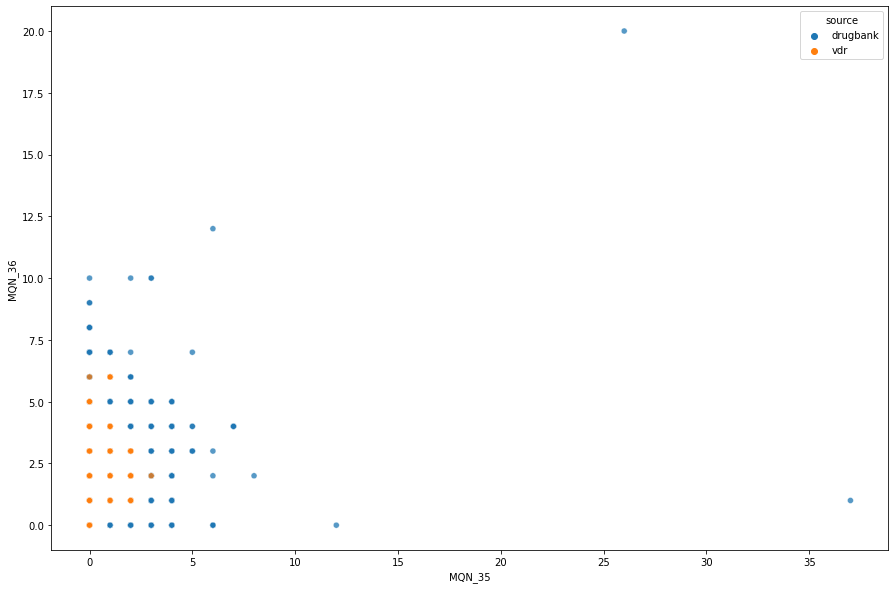

In [44]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_35",
                      y="MQN_36",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# PCA

In [45]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
df = df.join(pd.DataFrame(pca.transform(df[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

In [46]:
df

index                                             Smiles    source  \
0         0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1         1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2         2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3         3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4         4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   
...     ...                                                ...       ...   
7751   7751       COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7752   7752        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7753   7753  C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...       vdr   
7754   7754  CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...       vdr   
7755   7755        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   

                                                 rdmol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf3a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bfee0>   
2     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf760>   
3     <rdkit.Chem.rdchem.Mol object at 0x7f20df4ceda0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7f20df2f1030>   
...                                                ...   
7751  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0aff30>   
7752  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1030>   
7753  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b10d0>   
7754  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1170>   
7755  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1210>   

                                                    fps  pChEMBL_value  HBA  \
0     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   29   
1     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
2     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   15   
3     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
4     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   12   
...                                                 ...            ...  ...   
7751  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...           5.54    6   
7752  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           6.18    6   
7753  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           8.95    3   
7754  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...           6.53    5   
7755  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    6   

      HBD           MW     LogP  ...    PCA_33    PCA_34    PCA_35    PCA_36  \
0      28  2178.985813 -8.11643  ...  0.144203  0.108107  0.041930 -0.007484   
1      17  1268.641439 -3.10570  ...  0.075177  0.013145  0.046454 -0.018734   
2      14  1068.426955 -4.13203  ...  0.205123 -0.256083 -0.060524 -0.136926   
3      17  1429.669818 -0.50613  ...  0.033103  0.018208  0.053316 -0.023497   
4       5  1201.841368  3.26900  ...  0.319249 -0.316943 -0.022306  0.037911   
...   ...          ...      ...  ...       ...       ...       ...       ...   
7751    0   381.157623  4.34322  ...  0.017961 -0.001748  0.012963 -0.002208   
7752    0   367.141973  3.95312  ...  0.020477 -0.000926  0.014960 -0.002234   
7753    3   416.329045  5.70470  ... -0.034651  0.020318  0.005858  0.010662   
7754    2   541.424343  6.70422  ...  0.014831 -0.068461 -0.012280  0.029676   
7755    0   367.141973  3.95312  ...  0.020477 -0.000926  0.014960 -0.002234   

        PCA_37    PCA_38    PCA_39    PCA_40    PCA_41    PCA_42  
0     0.033820  0.055608  0.008332 -0.011454  0.002576  0.001009  
1    -0.002471 -0.008024 -0.007156 -0.004781 -0.001847  0.004029  
2     0.008876  0.043202 -0.017549 -0.002644  0.002480  0.005735  
3     0.001940 -0.002336 -0.009909 -0.007254  0.000206  0.001355  
4    -0.054683 -0.007938  0.007233  0.012432 -0.001895  0.001871  
...        ...       ...       ...       ...       ...       ...  
7751  0.016019 -0

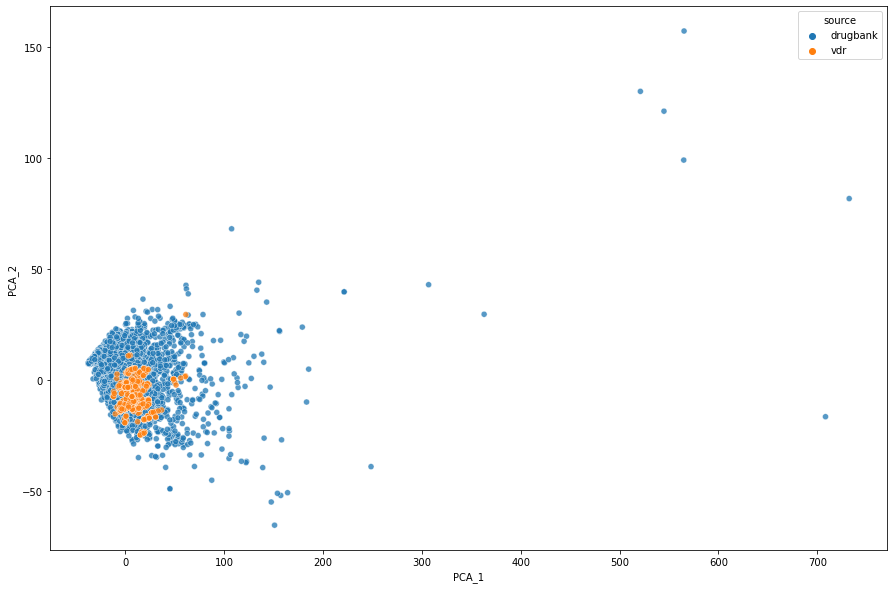

In [47]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

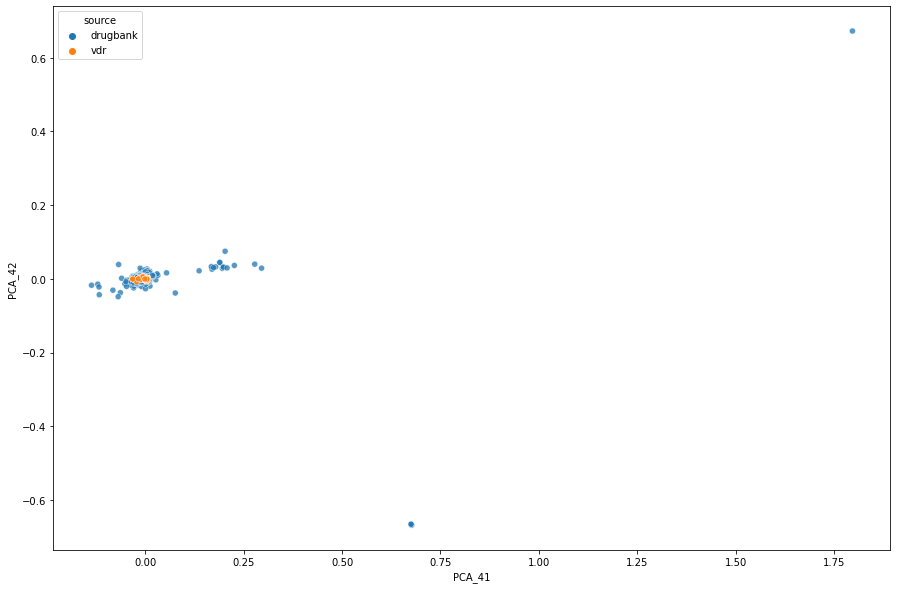

In [48]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_41", y="PCA_42",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [49]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

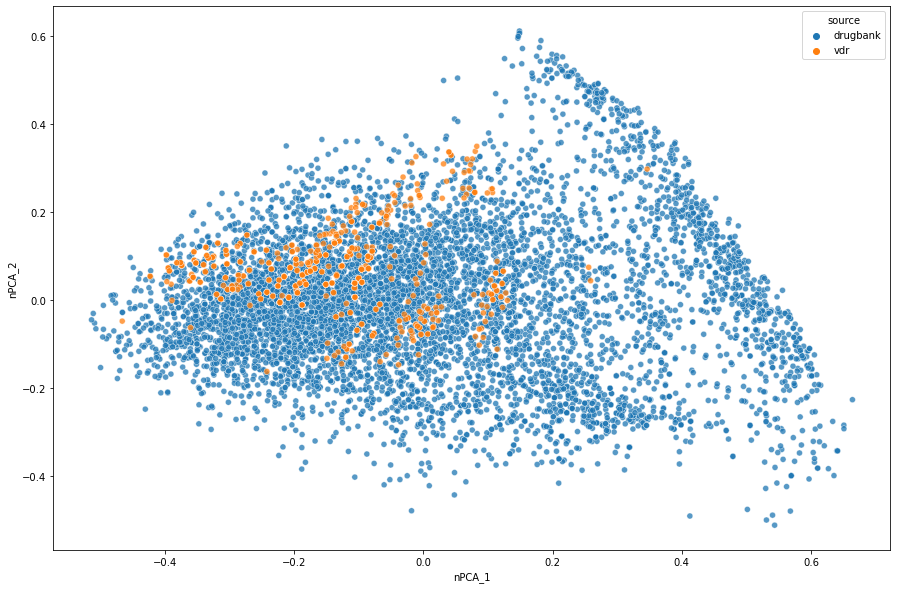

In [50]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

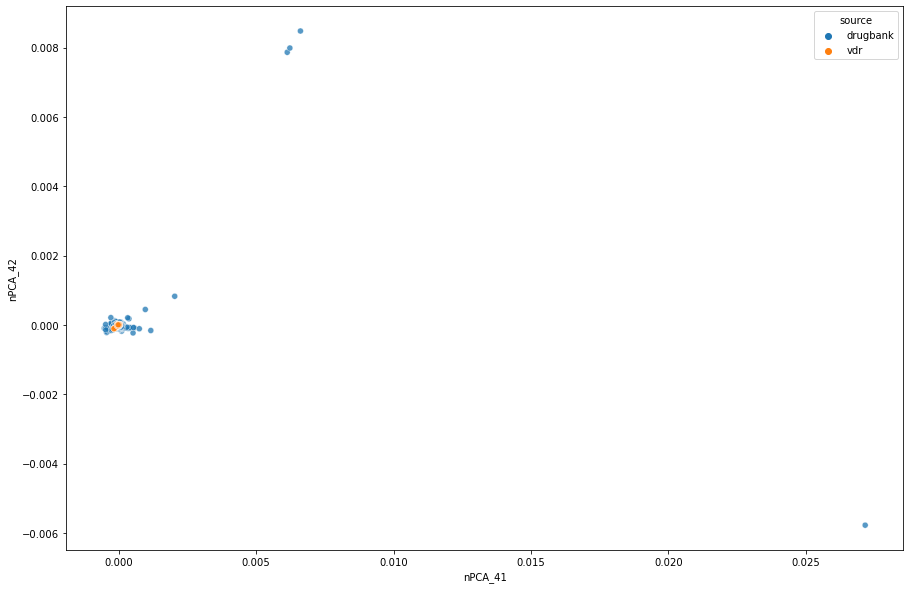

In [51]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_41",
                      y="nPCA_42",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# MDS

In [52]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [53]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

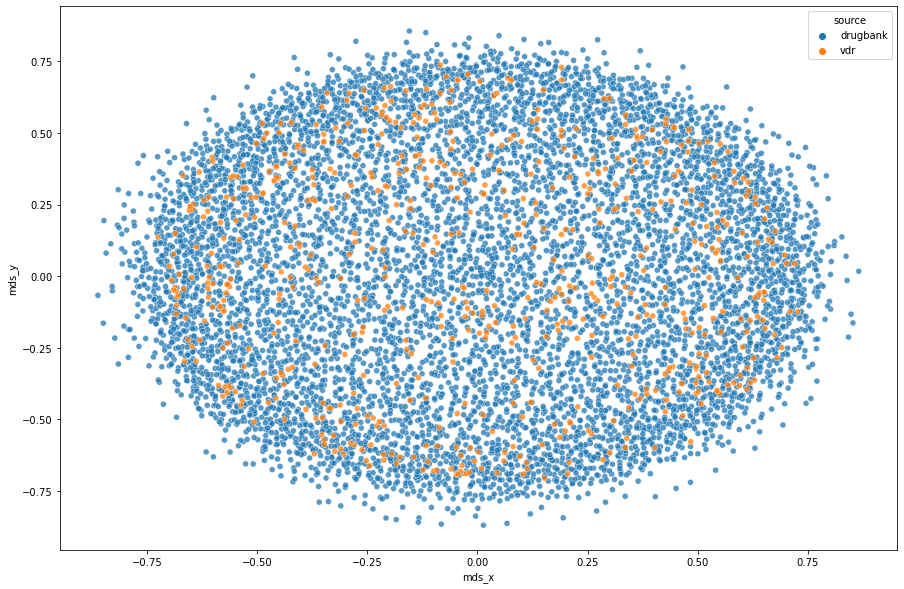

In [54]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# t-SNE

In [55]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [56]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

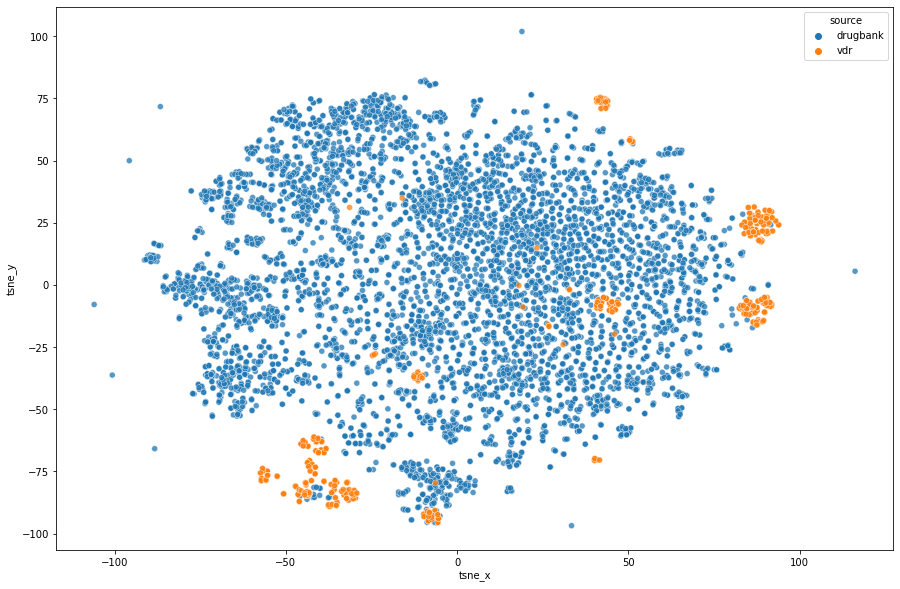

In [57]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Use case 1:Diversity picker

In [59]:
def distance_function(index1, index2, *args, fingerprints=df["fps"],
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [60]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45))
df["picked"] = df.index.isin(picked)

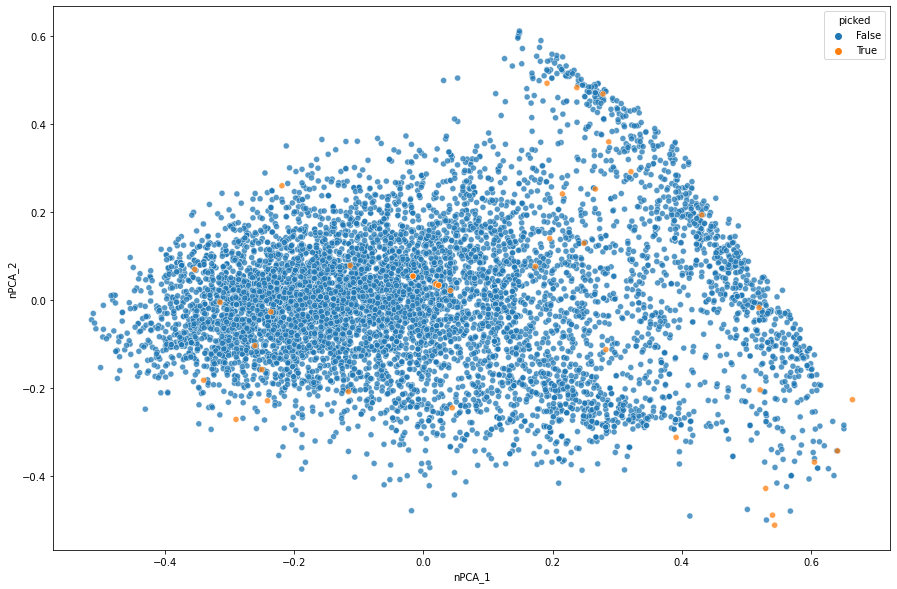

In [61]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

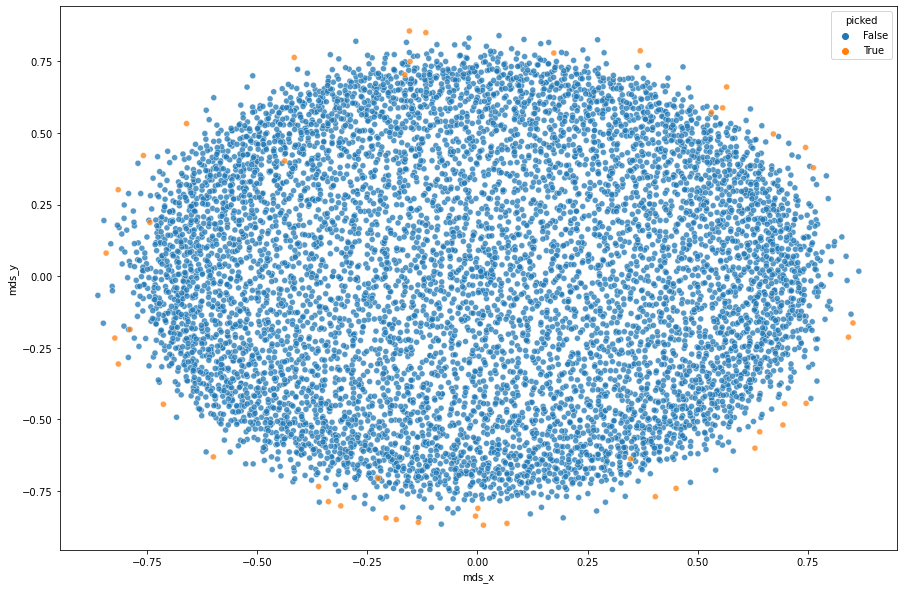

In [62]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

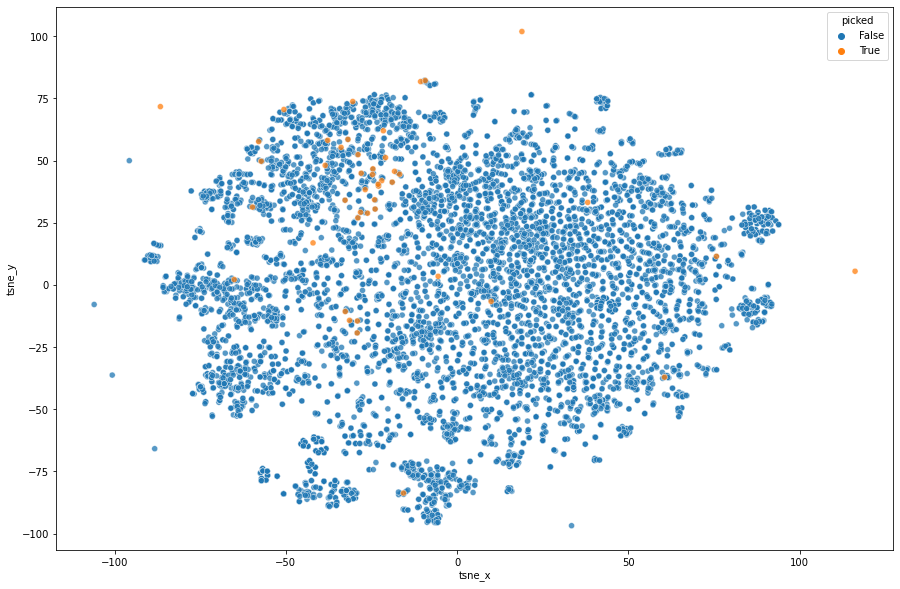

In [63]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

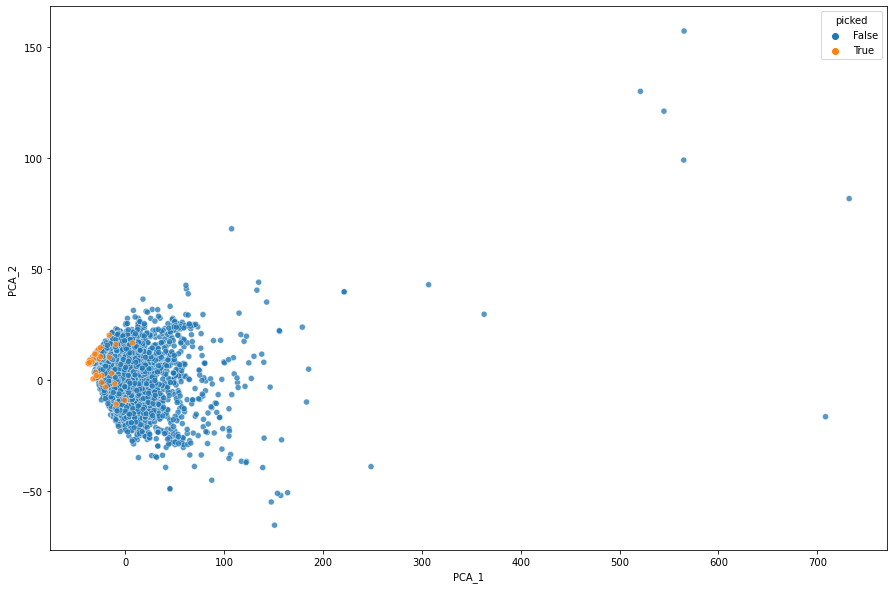

In [64]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1",
                      y="PCA_2",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Use case2: Activities or descriptors

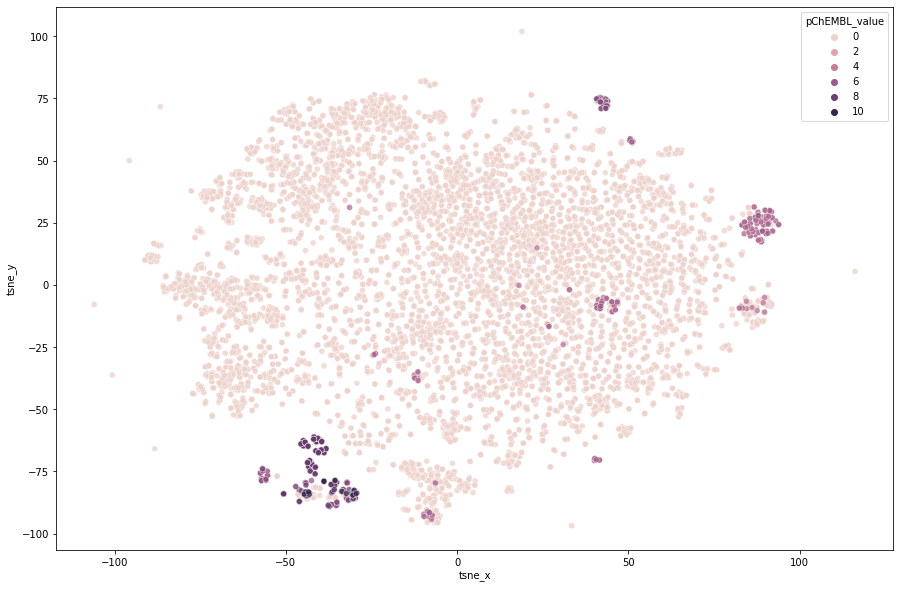

In [65]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

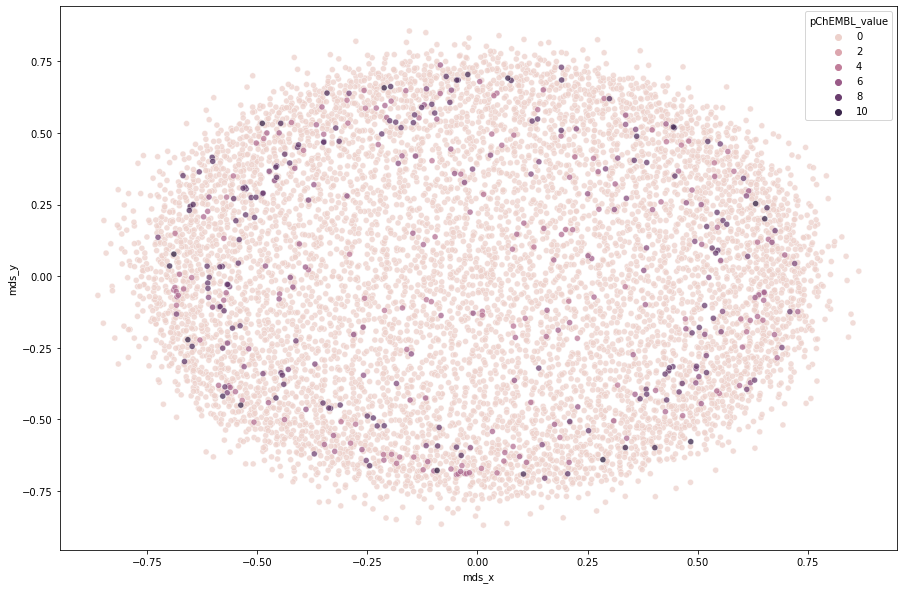

In [66]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

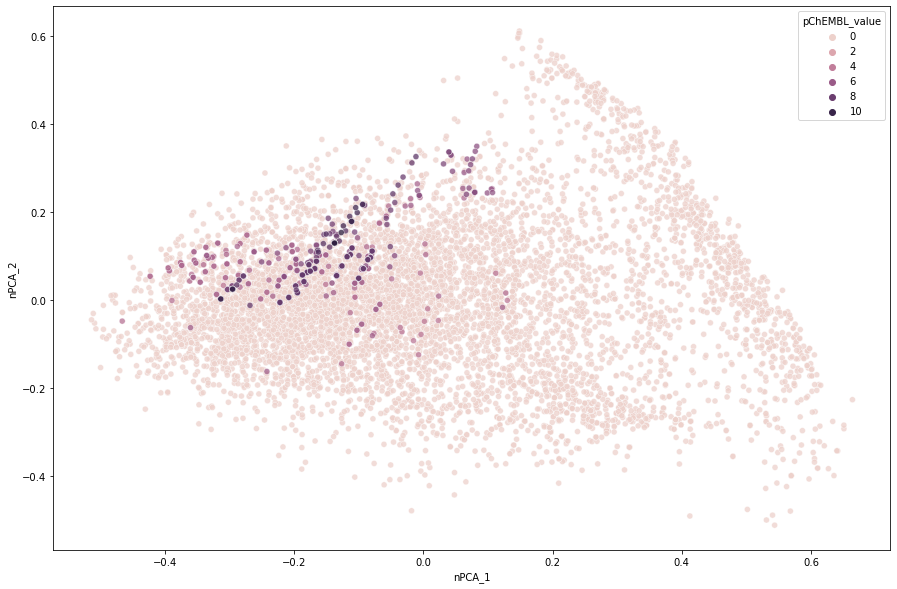

In [67]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

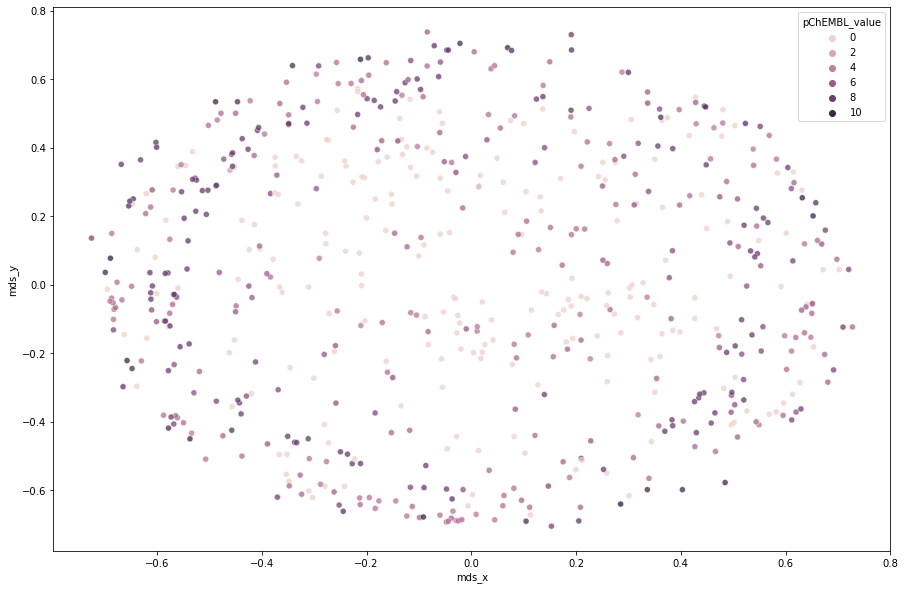

In [70]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df[df.source == "vdr"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

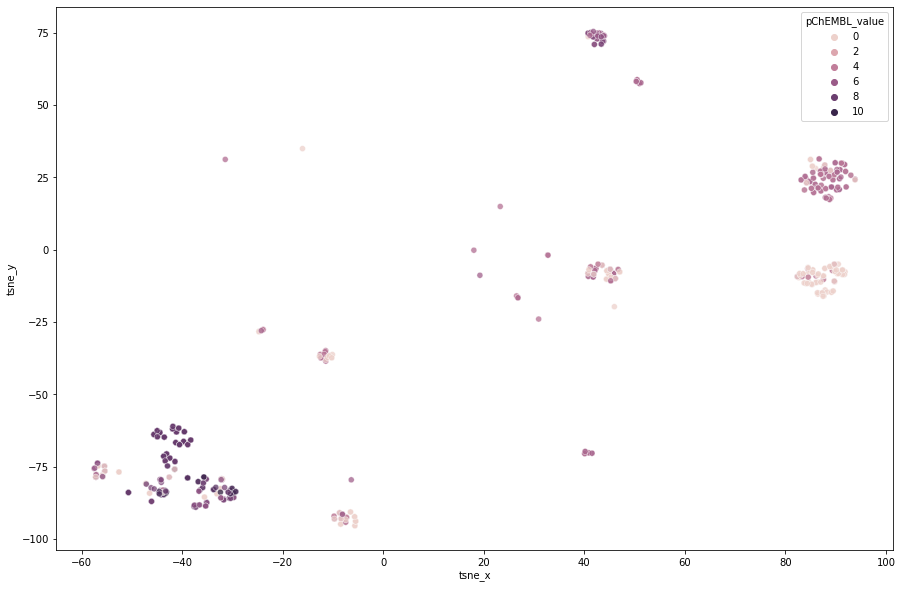

In [71]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df[df.source == "vdr"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

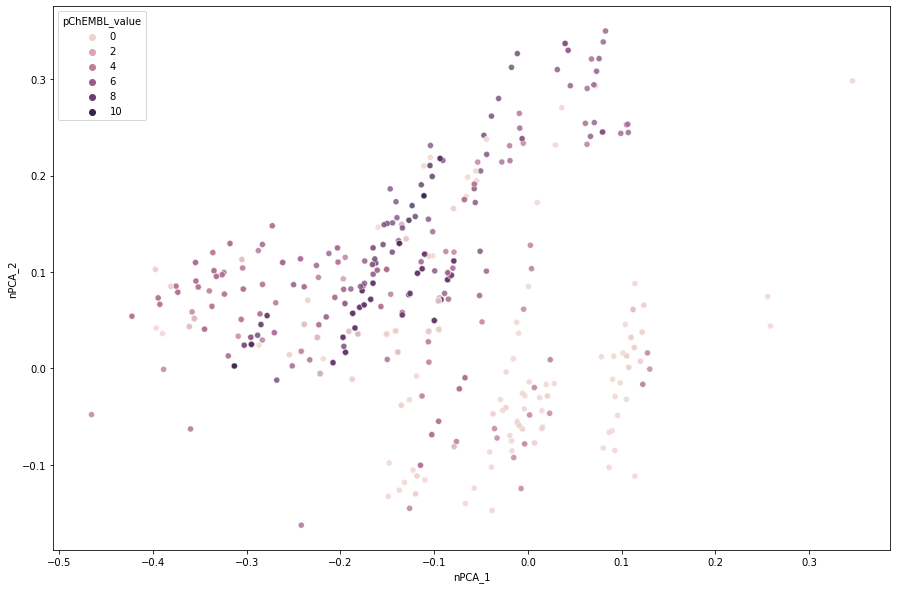

In [72]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "vdr"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [89]:
df


index                                             Smiles    source  \
0         0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...  drugbank   
1         1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...  drugbank   
2         2  N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...  drugbank   
3         3  CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...  drugbank   
4         4  C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...  drugbank   
...     ...                                                ...       ...   
7751   7751       COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7752   7752        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   
7753   7753  C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...       vdr   
7754   7754  CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...       vdr   
7755   7755        COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1       vdr   

                                                 rdmol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf3a0>   
1     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bfee0>   
2     <rdkit.Chem.rdchem.Mol object at 0x7f20df4bf760>   
3     <rdkit.Chem.rdchem.Mol object at 0x7f20df4ceda0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7f20df2f1030>   
...                                                ...   
7751  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0aff30>   
7752  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1030>   
7753  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b10d0>   
7754  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1170>   
7755  <rdkit.Chem.rdchem.Mol object at 0x7f20dc0b1210>   

                                                    fps  pChEMBL_value  HBA  \
0     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   29   
1     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
2     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   15   
3     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00   16   
4     [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...           0.00   12   
...                                                 ...            ...  ...   
7751  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...           5.54    6   
7752  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           6.18    6   
7753  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           8.95    3   
7754  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...           6.53    5   
7755  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.00    6   

      HBD           MW     LogP  ...   nPCA_39   nPCA_40       nPCA_41  \
0      28  2178.985813 -8.11643  ...  0.000044 -0.000017  1.093130e-06   
1      17  1268.641439 -3.10570  ...  0.000086  0.000011 -4.489697e-08   
2      14  1068.426955 -4.13203  ...  0.000390 -0.002036 -7.673518e-05   
3      17  1429.669818 -0.50613  ...  0.000110 -0.000034  1.668193e-06   
4       5  1201.841368  3.26900  ...  0.000296 -0.005272 -2.442251e-04   
...   ...          ...      ...  ...       ...       ...           ...   
7751    0   381.157623  4.34322  ... -0.000002 -0.000024 -2.269826e-05   
7752    0   367.141973  3.95312  ... -0.000009 -0.000024 -2.373439e-05   
7753    3   416.329045  5.70470  ...  0.000222  0.000118  1.162215e-05   
7754    2   541.424343  6.70422  ...  0.000111  0.000062  5.522381e-06   
7755    0   367.141973  3.95312  ... -0.000009 -0.000024 -2.373439e-05   

           nPCA_42     mds_x     mds_y     tsne_x     tsne_y  picked  vazba=  
0    -2.290378e-06  0.407878  0.151385 -15.973543 -23.130220   False      27  
1    -7.256001e-06  0.527644 -0.048662 -16.303026 -21.192148   False      12  
2    -6.451415e-05 -0.070452  0.522718 -17.673319 -25.705759   False      12  
3    -3.458951e-06 -0.411912  0.235225 -16.720888 -19.503195   False      13  
4    -1.330746e-04  0.106940 -0.698172 -15.792061 -34.152264   False      12  
...            ...       ...       ...        ...        ...     ...     ...  
7751 

In [88]:
df['vazba='] = [df['Smiles'][x].count('=') for x in range(len(df))]

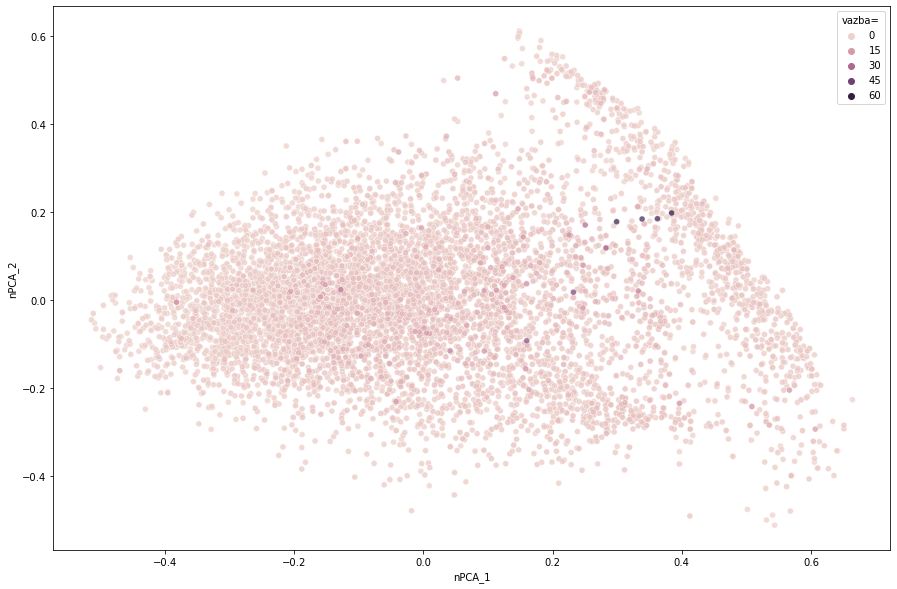

In [91]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values('vazba='),
                      hue="vazba=",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

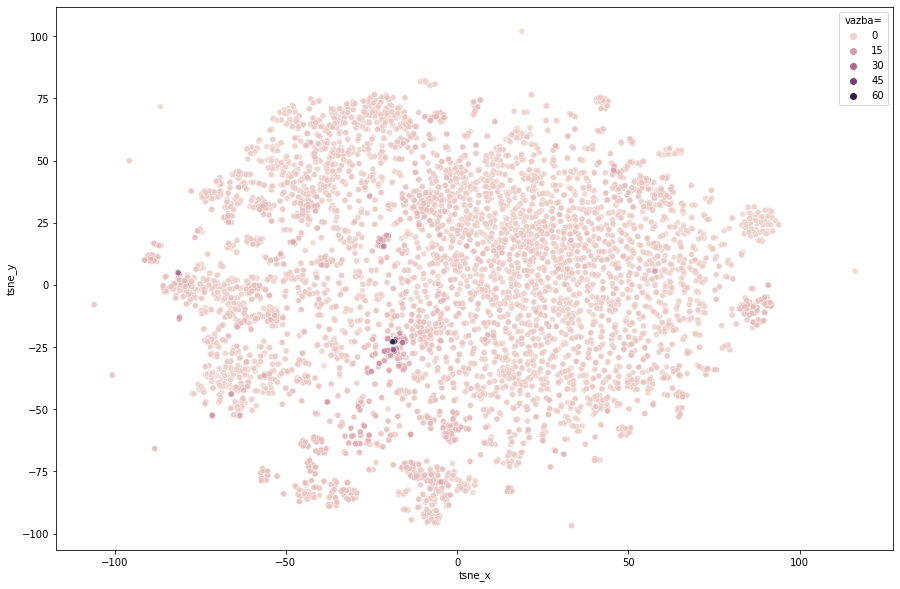

In [92]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values('vazba='),
                      hue="vazba=",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

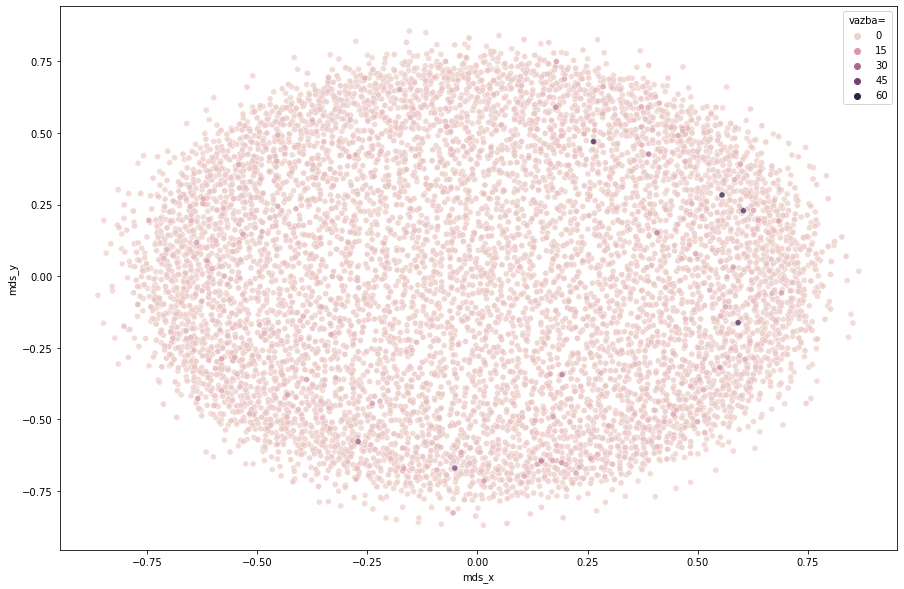

In [93]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values('vazba='),
                      hue="vazba=",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )